In [1]:
import pandas as pd
import numpy as np 
import re

In [2]:
# Read the scraped data

df = pd.read_csv(r'movies_2004_2023.csv')

In [3]:
df.head()

,Year,Month,Day,Title,Link,List,Genres,Budget,Box office
0,2004,1,9.0,Chasing Liberty,/wiki/Chasing_Liberty,"['romantic comedy', '$23 million[1]', '$12 mil...",romantic comedy,$23 million[1],$12 million[1]
1,2004,1,16.0,Along Came Polly,/wiki/Along_Came_Polly,"[' romantic comedy', '$42 million', '$178.3 mi...",romantic comedy,$42 million,$178.3 million[1]
2,2004,1,16.0,Torque,/wiki/Torque_(film),[' action film directed by Joseph Kahn (in his...,action film directed by Joseph Kahn (in his f...,$40 million[1],$46.5 million[1]
3,2004,1,22.0,D.E.B.S.,/wiki/D.E.B.S._(2004_film),"[' action comedy', '$3.5 million[2]', '$97,446...",action comedy,$3.5 million[2],"$97,446[3]"
4,2004,1,23.0,The Butterfly Effect,/wiki/The_Butterfly_Effect,"[' science fiction thriller', '$13 million[1]'...",science fiction thriller,$13 million[1],$96.8 million[2]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        2938 non-null   int64  
 1   Month       2938 non-null   int64  
 2   Day         2938 non-null   float64
 3   Title       2938 non-null   object 
 4   Link        2938 non-null   object 
 5   List        2938 non-null   object 
 6   Genres      2938 non-null   object 
 7   Budget      2937 non-null   object 
 8   Box office  2938 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 206.7+ KB


### Cleaning the Budget col

In [5]:
df['Budget'] = df['Budget'].str.split('[').str.get(0)
df['Box office'] = df['Box office'].str.split('[').str.get(0)
df.tail(3)

,Year,Month,Day,Title,Link,List,Genres,Budget,Box office
2935,2023,12,25.0,The Color Purple,/wiki/The_Color_Purple_(2023_film),"[' coming-of-age musical period drama', '$90–1...",coming-of-age musical period drama,$90–100 million,$47.2 million
2936,2023,12,25.0,The Boys in the Boat,/wiki/The_Boys_in_the_Boat_(film),"[' biographical sports drama', '$40 million[4]...",biographical sports drama,$40 million,$24.8 million
2937,2023,12,25.0,Ferrari,/wiki/Ferrari_(2023_film),"[' biographical sports drama', '$95 million[4]...",biographical sports drama,$95 million,$14.7 million


#### Handle the budget with the - (dash)

In [6]:
df.rename(columns={'Budget':'Budget2'}, inplace=True)
df['Budget2'] = df['Budget2'].str.replace(r'–', '-')

In [7]:
mask = df['Budget2'].str.find('-')
mask = mask != -1

(df.loc[mask, 'Budget2'].str.contains('million', case=False)).any()

True

In [8]:
(df.loc[mask, 'Budget2'].str.contains('million', case=False)).value_counts()

Budget2
True     386
False      1
Name: count, dtype: int64

In [9]:
df.drop(df.loc[df['Budget2'].isna()].index, inplace=True)

In [10]:
df.loc[(mask) & (~(df['Budget2'].str.contains('million', case=False))), 'Budget2']

1531    $50,000-100,000
Name: Budget2, dtype: object

In [11]:
'''
This function gives the mean of the budgets with format: xyz-xyz.
For example, for 10-20... the function gives 15.
'''

def get_mean_budget(x):
    pattern = r'\$?([\d\.]*)-\$?([\d\.]*)'
    if re.search('million', x):
        try:
            finds = re.findall(pattern, x)[0]
            return (float(finds[0]) + float(finds[1])) / 2
        except:
            pattern = r'\$?([\d\.]*)[\s\w]*-[\s\$]?([\d\.]*)'
            finds = re.findall(pattern, x)[0]
            return (float(finds[0]) + float(finds[1])) / 2 
    else:
        pattern = r'\$?([\d,]*)[\s\w]*-[\s\$]?([\d,]*)'
        finds = re.findall(pattern, x)[0]
        return (float(finds[0].replace(',', '')) + float(finds[1].replace(',', ''))) / 2000000

df['Budget'] = df.loc[mask, 'Budget2'].apply(get_mean_budget)

In [12]:
df.loc[mask, 'Budget'][:5]

8     24.00
27    52.50
28     2.35
45    65.00
49    22.50
Name: Budget, dtype: float64

#### Handle the budget without 'million'

In [13]:
mask = df['Budget'].isna()

(df.loc[mask, 'Budget2'].str.contains('million')).value_counts()

Budget2
True     2475
False      75
Name: count, dtype: int64

In [14]:
mask2 = (df.loc[mask, 'Budget2'].str.find('million') == -1)
df[mask].loc[mask2, 'Budget2'][:10]

141                 $2,000,000
152                   $500,000
220                   $750,000
298                   $950,000
345                   $700,000
372                   $100,000
404                   $500,000
441    $18,000,000 (estimated)
478                   $750,000
498                   $150,000
Name: Budget2, dtype: object

In [15]:
'''
This function gives the budgets in Millions.
For example, for 100,000... the function gives 0.1 (M).
'''

def thousands_budget(x):
    pattern = r'.?[\$]([\d,]+)'
    try:
        finds = re.findall(pattern, x)[0].replace(',','')
        return float(finds) / 1000000
    except:
        return None

df.loc[(mask & mask2), 'Budget'] = df.loc[(mask & mask2), 'Budget2'].apply(thousands_budget)
df.loc[(mask & mask2), 'Budget'][:10]

141     2.00
152     0.50
220     0.75
298     0.95
345     0.70
372     0.10
404     0.50
441    18.00
478     0.75
498     0.15
Name: Budget, dtype: float64

#### Handle the budget with 'million'

In [16]:
# mask in this case is df['Budget'].isna()

mask2 = (df.loc[mask, 'Budget2'].str.contains('million'))
df.loc[(mask2 & mask), 'Budget2'][:7]

0     $23 million
1     $42 million
2     $40 million
3    $3.5 million
4     $13 million
5     $22 million
6     $50 million
Name: Budget2, dtype: object

In [17]:
def millions_budget(x):
    pattern = r'[\$€£]([\d\.]+)'
    finds = re.findall(pattern, x)
    if len(finds) == 0:
        return None
    else:
        return float(finds[0])

df.loc[(mask & mask2), 'Budget'] = df.loc[(mask & mask2), 'Budget2'].apply(millions_budget)

In [18]:
df.loc[(mask & mask2), 'Budget'][:7]

0    23.0
1    42.0
2    40.0
3     3.5
4    13.0
5    22.0
6    50.0
Name: Budget, dtype: float64

In [19]:
df['Budget2'].str.contains('billion').any()

False

In [20]:
df['Budget'].isna().sum()

17

In [21]:
df = df[df['Budget'].notna()]

In [22]:
df = df[df['Budget'] > 0.010]

### Cleaning Box office col

In [23]:
mask = (df['Box office'].str.find('million') == -1)
mask.sum()

300

In [24]:
df.loc[mask, 'Box office'][0:15]

3          $97,446
19      $1,491,434
53     $12,009,070
58     $21,839,377
135     $1,126,258
141     $1,691,706
144     $4,143,652
157       $251,495
177       $192,186
186     $3,344,431
218       $689,028
220       $537,667
262       $454,026
308    $29,612,137
309     $3,306,629
Name: Box office, dtype: object

#### Handle the box office without 'million' and 'billion'

In [25]:
mask2 = (df['Box office'].str.find('billion') == -1)
mask2.sum()

2868

In [26]:
df = df.rename(columns={'Box office':'Box office2'})

In [27]:
pattern = r'\$([\d,]+)'

df.loc[(mask & mask2),'Box office'] = df.loc[(mask & mask2),
                                             'Box office2'].str.findall(pattern).str.get(0).str.replace(',', '').astype('float32') / 1000000

In [28]:
df.loc[(mask & mask2),'Box office'][:10]

3       0.097446
19      1.491434
53     12.009070
58     21.839376
135     1.126258
141     1.691706
144     4.143652
157     0.251495
177     0.192186
186     3.344431
Name: Box office, dtype: float64

#### Handle the Box office with 'million'

In [29]:
df.loc[df['Box office2'].str.contains(',') & df['Box office2'].str.contains('million'),
       ['Box office', 'Box office2']][:7]

,Box office,Box office2
1246,NaN,"$2,5 million"


In [30]:
df.drop(index=1246, inplace=True)

In [31]:
pattern = r'\$([\d,\.]+)'

mask = (df['Box office2'].str.find('million') != -1)
df.loc[mask,'Box office'] = df.loc[mask,
                          'Box office2'].str.findall(pattern).str.get(0).str.replace(',', '').astype(float)

In [32]:
df.loc[mask,
       ['Box office', 'Box office2']][:7]

,Box office,Box office2
0,12.0,$12 million
1,178.3,$178.3 million
2,46.5,$46.5 million
4,96.8,$96.8 million
5,21.3,$21.3 million
6,6.8,$6.8 million
7,50.6,$50.6 million


#### Handle the Box office with 'billion'

In [33]:
mask = (df['Box office2'].str.find('billion') != -1)
mask.sum()

48

In [34]:
df['Box office'].isna().sum()

53

In [35]:
df.loc[mask, 'Box office'] = df.loc[mask, 'Box office2'].str.findall(pattern).str.get(0).astype(float) * 1000

In [36]:
df.loc[mask, ['Box office','Box office2']][:5]

,Box office,Box office2
329,1066.0,$1.066 billion
725,1006.0,$1.006billion
973,2923.0,$2.923 billion
1077,1067.0,$1.067 billion
1118,2923.0,$2.923 billion


In [37]:
df[df['Box office'].isna()]

,Year,Month,Day,Title,Link,List,Genres,Budget2,Box office2,Budget,Box office
627,2007,12,28.0,The Orphanage,/wiki/The_Orphanage_(2007_film),"['gothic supernatural horror', '€4.5 million[3...",gothic supernatural horror,€4.5 million,€65 million,4.5,NaN
838,2009,1,23.0,Donkey Punch,/wiki/Donkey_Punch_(2008_film),"[' horror thriller', '£1 million[2][3]', '£694...",horror thriller,£1 million,"£694,422",1.0,NaN
1104,2010,8,6.0,The Disappearance of Alice Creed,/wiki/The_Disappearance_of_Alice_Creed,"[' neo-noir', '$1.5 million[3]', '£554,832[2]']",neo-noir,$1.5 million,"£554,832",1.5,NaN
1221,2011,7,29.0,Attack the Block,/wiki/Attack_the_Block,"[' science fiction comedy horror', '£8 million...",science fiction comedy horror,£8 million,£4.1 million,8.0,NaN
1393,2012,6,29.0,Unforgivable,/wiki/Unforgivable_(2011_film),"[' drama', '€7.5 million[1]', '€1.3 million[1]']",drama,€7.5 million,€1.3 million,7.5,NaN


In [38]:
df = df[df['Box office'].notna()]

### Cleaning Genres

In [41]:
df['Genres'] = df['Genres'].str.strip().str.split(' ')

In [42]:
# Sometimes we scraped the whole paragraph due to some irregularities
# in the page of Wikipedia. Here we handle this problem.

df['Genres'].apply(len).value_counts()

Genres
2     1274
1      698
3      640
4      199
5       31
10       8
6        7
15       6
11       5
13       5
18       4
12       4
7        4
16       4
9        3
14       3
22       2
21       2
34       1
28       1
33       1
25       1
23       1
20       1
29       1
42       1
35       1
17       1
30       1
Name: count, dtype: int64

In [44]:
df.loc[(df['Genres'].apply(len) == 5), 'Genres'][-5:]

2422           [science, fiction, black, comedy, slasher]
2448       [surrealist, neo-noir, black, comedy, mystery]
2736      [apocalyptic, political, satire, black, comedy]
2815    [live-action/animated, cartoon, musical, fanta...
2825      [stop-motion, animated, musical, dark, fantasy]
Name: Genres, dtype: object

In [45]:
df = df[(df['Genres'].apply(len) < 6)]

#### There are too many genres so I'll keep the ones with at least 2 movies per year

In [53]:
# I use MultiLabelBinarizer to transform a list of values in dummies.

from sklearn.preprocessing import MultiLabelBinarizer

s = df['Genres']

mlb = MultiLabelBinarizer()

df_genres = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
df_genres.head()

,,",",-American,-Australian,-Belgian,-British,-Canadian,-Danish,-French-Irish,-Hong,...,urban,vampire,vigilante,war,war-drama,western,where,wuxia,zombie,–Italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
(df_genres.sum(axis=0) > 38).sum()

24

In [58]:
# These are the genres we'll keep

col_genres = df_genres.columns.to_series()
col_to_keep = col_genres[(df_genres.sum(axis=0) > 38)].index.to_list()
col_to_keep

['action',
 'adventure',
 'animated',
 'biographical',
 'black',
 'buddy',
 'comedy',
 'comedy-drama',
 'crime',
 'drama',
 'epic',
 'fantasy',
 'fiction',
 'historical',
 'horror',
 'musical',
 'psychological',
 'romantic',
 'science',
 'sports',
 'superhero',
 'supernatural',
 'thriller',
 'war']

In [59]:
df_genres = df_genres[col_to_keep]
df_genres.head()

,action,adventure,animated,biographical,black,buddy,comedy,comedy-drama,crime,drama,...,horror,musical,psychological,romantic,science,sports,superhero,supernatural,thriller,war
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [60]:
df = pd.concat([df, df_genres], axis=1)
df.head()

,Year,Month,Day,Title,Link,List,Genres,Budget2,Box office2,Budget,...,horror,musical,psychological,romantic,science,sports,superhero,supernatural,thriller,war
0,2004,1,9.0,Chasing Liberty,/wiki/Chasing_Liberty,"['romantic comedy', '$23 million[1]', '$12 mil...","[romantic, comedy]",$23 million,$12 million,23.0,...,0,0,0,1,0,0,0,0,0,0
1,2004,1,16.0,Along Came Polly,/wiki/Along_Came_Polly,"[' romantic comedy', '$42 million', '$178.3 mi...","[romantic, comedy]",$42 million,$178.3 million,42.0,...,0,0,0,1,0,0,0,0,0,0
3,2004,1,22.0,D.E.B.S.,/wiki/D.E.B.S._(2004_film),"[' action comedy', '$3.5 million[2]', '$97,446...","[action, comedy]",$3.5 million,"$97,446",3.5,...,0,0,0,0,0,0,0,0,0,0
4,2004,1,23.0,The Butterfly Effect,/wiki/The_Butterfly_Effect,"[' science fiction thriller', '$13 million[1]'...","[science, fiction, thriller]",$13 million,$96.8 million,13.0,...,0,0,0,0,1,0,0,0,1,0
5,2004,1,23.0,Win a Date with Tad Hamilton!,/wiki/Win_a_Date_with_Tad_Hamilton!,"[' romantic comedy', '$22 million[2]', '$21.3 ...","[romantic, comedy]",$22 million,$21.3 million,22.0,...,0,0,0,1,0,0,0,0,0,0


### Ordinate the dataframe

In [61]:
df['Profit'] = df['Box office'] - df['Budget']
df['Profit perc'] = df['Profit'] * 100/ df['Budget']
df[['Box office', 'Budget', 'Profit', 'Profit perc']][:5]

,Box office,Budget,Profit,Profit perc
0,12.000000,23.0,-11.000000,-47.826087
1,178.300000,42.0,136.300000,324.523810
3,0.097446,3.5,-3.402554,-97.215829
4,96.800000,13.0,83.800000,644.615385
5,21.300000,22.0,-0.700000,-3.181818


In [64]:
new_col = [
    'Title','Budget','Profit','Box office','Profit perc',
    'Year','Month','Day'
]

new_col = new_col + col_to_keep

#### Convert every column but 'Title' to float32

In [65]:
df[new_col[1:]] = df[new_col[1:]].astype('float32')

In [66]:
df = df[new_col]
df[new_col[:10]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2842 entries, 0 to 2937
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        2842 non-null   object 
 1   Budget       2842 non-null   float32
 2   Profit       2842 non-null   float32
 3   Box office   2842 non-null   float32
 4   Profit perc  2842 non-null   float32
 5   Year         2842 non-null   float32
 6   Month        2842 non-null   float32
 7   Day          2842 non-null   float32
 8   action       2842 non-null   float32
 9   adventure    2842 non-null   float32
dtypes: float32(9), object(1)
memory usage: 144.3+ KB


In [73]:
df.isna().any().any()

False

## Determining the budget groups

In [82]:
budget_ulimit = df['Budget'].quantile(0.75) + 1.5*(df['Budget'].quantile(0.75) - df['Budget'].quantile(0.25))
budget_llimit = df['Budget'].quantile(0.25) - 1.5*(df['Budget'].quantile(0.75) - df['Budget'].quantile(0.25))
print(budget_ulimit, budget_llimit)

132.0 -60.0


This is also based on this resource: https://filmlifestyle.com/average-movie-budget/

In [84]:
df.loc[df['Budget'] > 100, 'Budget'].count()

361

In [85]:
df.loc[df['Budget'] < 20, 'Budget'].count()

1067

In [86]:
df.loc[(df['Budget'] > 20) & (df['Budget'] < 100), 'Budget'].count()

1236

In [92]:
budget_group = pd.cut(df['Budget'], [df['Budget'].min(),20, 100,df['Budget'].max()],
       labels=['low', 'mid', 'high'])
budget_group[:7]

0    mid
1    mid
3    low
4    low
5    mid
6    mid
7    low
Name: Budget, dtype: category
Categories (3, object): ['low' < 'mid' < 'high']

In [227]:
df['Budget group'] = budget_group

In [228]:
df.to_csv(r'movies_2004_2023_cleaned.csv',index=False)

# Start analysis

### Low budget

<Axes: >

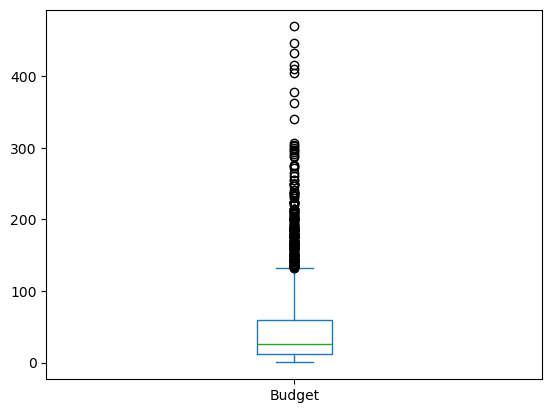

In [210]:
df['Budget'].plot.box()

I'll delete the movies with a too high profit perc. Their success is amazing and hard to replicate.

In [211]:
def get_limits(df):
    print('llimit', str(df.quantile(0.25) - 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('ulimit', str(df.quantile(0.75) + 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme llimit', str(df.quantile(0.25) - 3*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme ulimit', str(df.quantile(0.75) + 3*(df.quantile(0.75) - df.quantile(0.25))))

In [212]:
get_limits(df.loc[budget_group == 'low', 'Profit perc'])

llimit -639.9479150772095
ulimit 937.4687490463257
Extreme llimit -1231.4791641235352
Extreme ulimit 1528.9999980926514


In [213]:
(df.loc[budget_group == 'low', 'Profit perc'] > 1528).sum()

55

In [214]:
low_df = df.loc[(budget_group == 'low') & (df['Profit perc'] < 1528)]
low_df.shape

(1152, 32)

In [215]:
def profit_genre(df, genres, col):
    for i in genres:
        if df[i] == 1:
            df[i] = df[col]
    return df

#### I grab the genres that have at least 15 occurrences

In [216]:
low_df[genres].sum(axis=0)

action            76.0
adventure         17.0
animated          12.0
biographical      64.0
black             41.0
buddy             13.0
comedy           260.0
comedy-drama     154.0
crime             64.0
drama            332.0
epic              10.0
fantasy           23.0
fiction           42.0
historical        16.0
horror           156.0
musical           20.0
psychological     57.0
romantic         139.0
science           45.0
sports            24.0
superhero          9.0
supernatural      59.0
thriller         136.0
war               18.0
dtype: float32

In [217]:
low_genres = low_df[genres].sum(axis=0).loc[low_df[genres].sum(axis=0) > 15].index.tolist()
print(low_genres)

['action', 'adventure', 'biographical', 'black', 'comedy', 'comedy-drama', 'crime', 'drama', 'fantasy', 'fiction', 'historical', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'supernatural', 'thriller', 'war']


In [218]:
low_df_profit = low_df[low_genres+ ['Profit']].apply(profit_genre, genres=low_genres,
                                     col='Profit', axis=1)

low_df_profit[low_df_profit == 0] = np.nan

low_df_profit.head()

,action,adventure,biographical,black,comedy,comedy-drama,crime,drama,fantasy,fiction,...,horror,musical,psychological,romantic,science,sports,supernatural,thriller,war,Profit
3,-3.402554,NaN,NaN,NaN,-3.402554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.402554
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.800003,...,NaN,NaN,NaN,NaN,83.800003,NaN,NaN,83.800003,NaN,83.800003
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.599998,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.599998
9,5.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
13,NaN,NaN,NaN,NaN,18.299999,NaN,NaN,NaN,NaN,NaN,...,NaN,18.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.299999


### Basic exploration

<Axes: >

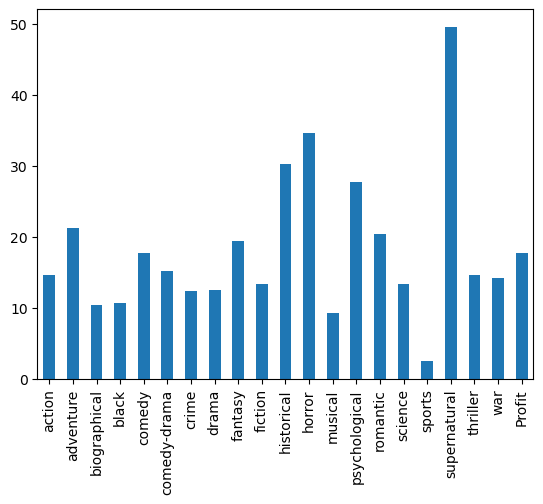

In [219]:
low_df_profit.mean(axis=0).plot.bar()

<Axes: >

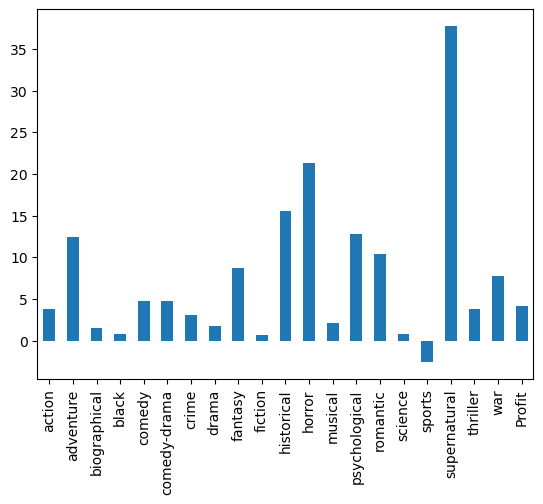

In [220]:
low_df_profit.quantile(q=0.5,axis=0).plot.bar()

In [221]:
low_df_profit_perc = low_df[low_genres+ ['Profit perc']].apply(profit_genre, genres=low_genres,
                                     col='Profit perc', axis=1)

low_df_profit_perc[low_df_profit_perc == 0] = np.nan

<Axes: >

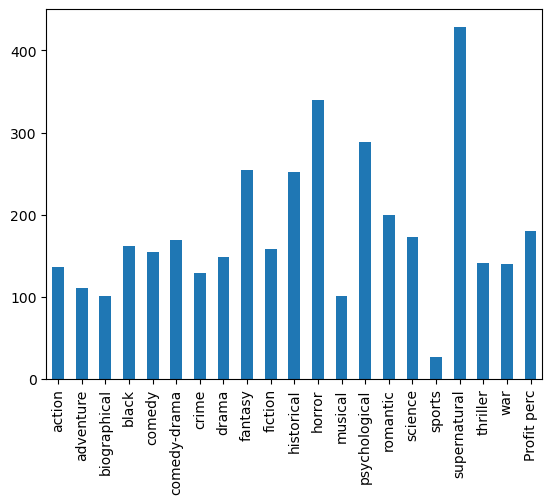

In [222]:
low_df_profit_perc.mean(axis=0).plot.bar()

<Axes: >

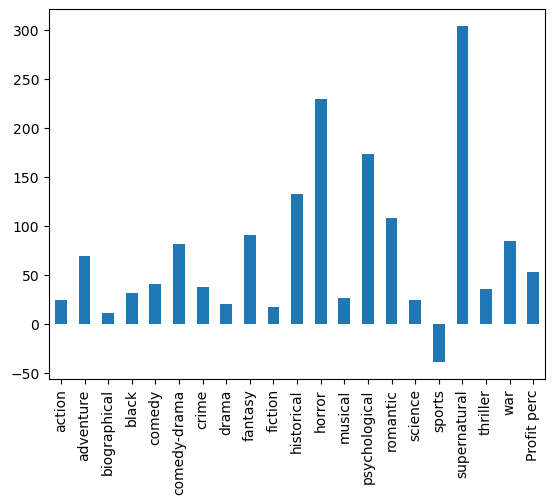

In [223]:
low_df_profit_perc.quantile(q=0.5, axis=0).plot.bar()